# 4 Imagenes

### Codigo base

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre
from scipy.stats import norm, median_abs_deviation
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from sklearn.decomposition import PCA

# Configure aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.dpi': 150})

# ==================================================================
# 1. Scientific Basis Generation
# ==================================================================

def fourier_basis_2d(grid_x, grid_y, num_components):
    """2D Fourier basis with tensor products"""
    def _fourier_1d(x, m):
        basis = np.zeros((m, len(x)))
        L = x.max() - x.min()
        for k in range(m):
            freq = k/L
            basis[k] = np.cos(2*np.pi*freq*x) if k>0 else 1.0
            norm = np.sqrt(np.trapezoid(basis[k]**2, x=x))
            basis[k] /= norm
        return basis
    
    fx = _fourier_1d(grid_x, num_components)
    fy = _fourier_1d(grid_y, num_components)
    
    return np.einsum('ix,jy->ijxy', fx, fy).reshape(num_components**2, *grid_x.shape, *grid_y.shape)

def legendre_basis(x, m):
    """Legendre polynomials by degree"""
    x_scaled = 2*(x - x.min())/(x.max() - x.min()) - 1
    basis = np.zeros((m, len(x)))
    
    for grado in range(m):
        coeffs = np.zeros(grado + 1)
        coeffs[-1] = 1
        leg_poly = Legendre(coeffs, domain=[-1,1])
        basis[grado] = leg_poly(x_scaled)
        basis[grado] /= np.sqrt(np.trapezoid(basis[grado]**2, x=x))
    
    return basis

# ==================================================================
# 2. Simulator Class
# ==================================================================

class ScientificSimulator:
    def __init__(self, M=25, seed=None):
        self.M = M
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Generator with seed
        
        # Parameters with seed
        self.alpha = np.clip(self.rng.beta(2, 2, M), 0.2, 0.8)
        self.eigenvalues = np.exp(-1.5*np.arange(M))
        
        # Deterministic bases (no seed required)
        self.fourier_base = fourier_basis_2d(np.linspace(0,1,100), 
                                            np.linspace(0,0.5,50), 
                                            int(np.sqrt(M)))
        self.legendre_base = legendre_basis(np.linspace(-1,1,200), M)
        
    def simulate(self, N=100):
        """Generate observations with controlled seed"""
        scores = self.rng.normal(scale=np.sqrt(self.eigenvalues),  # Use generator
                                size=(N, self.M))
        
        img_components = [np.sqrt(a)*base for a, base in zip(self.alpha, self.fourier_base)]
        fun_components = [np.sqrt(1-a)*base for a, base in zip(self.alpha, self.legendre_base)]
        
        images = np.tensordot(scores, img_components, axes=1)
        functions = np.tensordot(scores, fun_components, axes=1)
        
        return images, functions

# ==================================================================
# 3. Visualization Function
# ==================================================================

def plot_observations_only(images, functions):
    """Show only synthetic observations"""
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Synthetic image
    axs[0].imshow(images[0], cmap='viridis', aspect='auto', origin='lower')
    axs[0].set_title("Synthetic Image", fontweight='bold')
    axs[0].axis('off')
    
    # Synthetic function
    x = np.linspace(-1, 1, 200)
    axs[1].plot(x, functions[0], color='darkblue', linewidth=2)
    axs[1].set_title("Synthetic Function", fontweight='bold')
    axs[1].grid(alpha=0.3)
    axs[1].set_xlabel("Domain T2 [-1, 1]")
    
    plt.tight_layout()
    plt.show()

# ==================================================================
# 4. Functional Outlier Map Detector
# ==================================================================

class FOMDetector:
    def __init__(self, c=1.345, epsilon=1e-6):
        self.c = c  # Huber function parameter
        self.epsilon = epsilon
    
    def _huber(self, x):
        """Huber function for M-estimation"""
        return np.where(np.abs(x) <= self.c, (x/self.c)**2, 1.0)
    
    def _split_sample(self, Y):
        """Split sample into Y_b and Y_a"""
        n = len(Y)
        h = int((n + 1)//2)
        return Y[:h], Y[h:] if n%2 == 0 else Y[h-1:]
    
    def _initial_scale(self, Z, phi_inv=0.6745):
        """Initial scale estimation S0"""
        return np.median(np.abs(Z)) / phi_inv
    
    def _M_estimator(self, Z, S0, alpha):
        """M-estimation step"""
        rho_sum = np.sum(self._huber(Z/(S0 + self.epsilon)))
        return S0 * np.sqrt(rho_sum/(2*alpha*len(Z)))
    
    def calculate_DO(self, Y):
        """Calculate Directional Outlyingness"""
        Y_sorted = np.sort(Y)
        med = np.median(Y_sorted)
        Y_b, Y_a = self._split_sample(Y_sorted)
        
        # Calculate initial scales
        Z_a = Y_a - med
        Z_b = med - Y_b
        S0_a = self._initial_scale(Z_a)
        S0_b = self._initial_scale(Z_b)
        
        # Calculate alpha (numerical integral)
        x = np.linspace(0, 10, 1000)
        alpha = np.trapezoid(self._huber(x)*norm.pdf(x))
        
        # M-estimation
        S_a = self._M_estimator(Z_a, S0_a, alpha)
        S_b = self._M_estimator(Z_b, S0_b, alpha)
        
        # Calculate DO
        DO = np.zeros_like(Y)
        DO[Y >= med] = (Y[Y >= med] - med)/S_a
        DO[Y < med] = (med - Y[Y < med])/S_b
        
        return DO
    
    def calculate_FOM(self, images):
        """Calculate Functional Outlier Map for images"""
        n, height, width = images.shape
        JK = height * width
        W = 1/JK  # Uniform weights
        
        # Flatten images
        flat_images = images.reshape(n, -1)
        
        # Calculate DO for each pixel
        DO_matrix = np.array([self.calculate_DO(flat_images[:,pixel]) 
                              for pixel in range(flat_images.shape[1])])
        
        # fDO calculation
        fDO = np.sum(DO_matrix * W, axis=0)
        
        # vDO calculation
        std_DO = np.std(DO_matrix, axis=0)
        vDO = std_DO / (1 + fDO)
        
        # CFO calculation
        med_fDO = np.median(fDO)
        med_vDO = np.median(vDO)
        CFO = np.sqrt((fDO/med_fDO)**2 + (vDO/med_vDO)**2)
        
        # Outlier detection
        LDO = np.log(0.1 + fDO)
        cutoff = norm.ppf(0.995) * median_abs_deviation(LDO) + np.median(LDO)
        flags = LDO > cutoff
        
        return {'fDO': fDO, 'vDO': vDO, 'CFO': CFO, 'outliers': np.where(flags)[0]}

    def calculate_FOM_empiric(self, images):
        """Calculate Functional Outlier Map for images using empirical distribution"""
        n, height, width = images.shape
        JK = height * width
        W = 1/JK  # Uniform weights
        
        # Flatten images
        flat_images = images.reshape(n, -1)
        
        # Calculate DO for each pixel
        DO_matrix = np.array([self.calculate_DO(flat_images[:,pixel])
                            for pixel in range(flat_images.shape[1])])
        
        # fDO calculation
        fDO = np.sum(DO_matrix * W, axis=0)
        
        # vDO calculation
        std_DO = np.std(DO_matrix, axis=0)
        vDO = std_DO / (1 + fDO)
        
        # CFO calculation
        med_fDO = np.median(fDO)
        med_vDO = np.median(vDO)
        CFO = np.sqrt((fDO/med_fDO)**2 + (vDO/med_vDO)**2)
        
        # Outlier detection usando cuantiles empíricos
        LDO = np.log(0.1 + fDO)
        # Usamos el cuantil empírico directamente
        cutoff = np.quantile(LDO, 0.995)
        flags = LDO > cutoff
        
        return {'fDO': fDO, 'vDO': vDO, 'CFO': CFO, 'outliers': np.where(flags)[0]}
# ==================================================================
# 5. Functional Component Analysis (FCP)
# ==================================================================

def prepare_image_data(images, outliers):
    """Filter outliers from image tensor"""
    return np.delete(images, outliers, axis=0)

def create_penalty_matrices(image_tensor):
    """Create penalty matrices Pv and Pw as in R"""
    _, n_rows, n_cols = image_tensor.shape
    
    # First-order difference matrix (vertical direction)
    Dv = np.eye(n_rows) - np.eye(n_rows, k=1)  # Equivalent to diff(diag(n_rows)) in R
    Dv = Dv[:-1]  # Remove last row for dimension (n-1 x n)
    Pv = Dv.T @ Dv
    
    # Difference matrix for horizontal direction
    Dw = np.eye(n_cols) - np.eye(n_cols, k=1)
    Dw = Dw[:-1]
    Pw = Dw.T @ Dw
    
    return Pv, Pw

class FCP_TPA:
    def __init__(self, K=3, penMat=None, alphaRange=None, maxIter=20):
        self.K = K
        self.penMat = penMat
        self.alphaRange = alphaRange
        self.maxIter = maxIter
        
    def fit(self, X):
        """Simplified implementation for demonstration"""
        # Regularized tensor decomposition
        self.d = np.linalg.svd(X.reshape(X.shape[0], -1), 
                          compute_uv=False)[:self.K]
        
        # Principal components (simulation)
        self.V = np.random.randn(X.shape[1], self.K)
        self.W = np.random.randn(X.shape[2], self.K)
        
        return self

def plot_fcp_results(fcp_result, image_tensor):
    """Enhanced visualization with emphasis on statistical metrics"""
    plt.figure(figsize=(15, 10))
    K = fcp_result.K
    var_exp = fcp_result.d**2 / np.sum(fcp_result.d**2)
    cum_var = np.cumsum(var_exp)
    
    # Configure 3x3 grid for better organization
    gs = plt.GridSpec(3, 3)
    
    # ------------------------------------------
    # 1. Variance Panel (Top-Left)
    # ------------------------------------------
    ax1 = plt.subplot(gs[0, 0])
    bars = ax1.bar(range(K), var_exp, color='#1f77b4', alpha=0.7)
    ax1.plot(range(K), cum_var, 'ro--', markersize=8)
    ax1.set_title("Explained Variance by Component", fontsize=12, pad=15)
    ax1.set_xticks(range(K))
    ax1.set_xticklabels([f'PC{i+1}' for i in range(K)])
    ax1.set_ylim(0, 1.1)
    ax1.grid(axis='y', alpha=0.3)
    
    # Statistical annotations
    for i, (v, cv) in enumerate(zip(var_exp, cum_var)):
        ax1.text(i, v + 0.05, f'{v*100:.1f}%', ha='center', color='#1f77b4')
        ax1.text(i, cv + 0.05, f'{cv*100:.1f}%', ha='center', color='red')

    # ------------------------------------------
    # 2. Scores Distribution (Top-Center)
    # ------------------------------------------
    ax2 = plt.subplot(gs[0, 1])
    scores = image_tensor.reshape(len(image_tensor), -1) @ np.outer(fcp_result.V[:,0], fcp_result.W[:,0]).flatten()
    ax2.hist(scores, bins=20, color='#2ca02c', alpha=0.7)
    ax2.set_title(f"Scores Distribution - PC1\n(Var: {var_exp[0]*100:.1f}%)", fontsize=12)
    ax2.set_xlabel("Score Values")
    ax2.grid(alpha=0.3)

    # ------------------------------------------
    # 3. Variance Map (Top-Right)
    # ------------------------------------------
    ax3 = plt.subplot(gs[0, 2])
    variance_map = np.var(image_tensor, axis=0)
    ax3.imshow(variance_map.T[::-1], cmap='hot', aspect='auto')
    ax3.set_title("Global Variance Map", fontsize=12)
    ax3.axis('off')
    plt.colorbar(ax3.images[0], ax=ax3, shrink=0.7).set_label('Variance')

    # ------------------------------------------
    # 4. Eigenimages with Statistics (Rows 2-3)
    # ------------------------------------------
    eigen_images = [np.outer(fcp_result.V[:,k], fcp_result.W[:,k]) for k in range(K)]
    vmax = max(np.abs(eigenimg).max() for eigenimg in eigen_images)
    
    for k in range(K):
        ax = plt.subplot(gs[1 + k//3, k%3])
        img = eigen_images[k].T[::-1]
        im = ax.imshow(img, cmap='RdBu', vmin=-vmax, vmax=vmax)
        
        # Statistics per eigenimage
        stats_text = f"""d_k: {fcp_result.d[k]:.2f}
        Var: {var_exp[k]*100:.1f}%
        Min: {img.min():.2f}
        Max: {img.max():.2f}"""
        
        ax.text(0.05, 0.95, stats_text, 
                transform=ax.transAxes, 
                color='black', 
                fontsize=9, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))
        
        ax.set_title(f"Principal Component {k+1}", fontsize=11)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Statistical Analysis of Functional Principal Components", 
                 fontsize=14, y=0.98)

# ==================================================================
# 6. Multivariate FPCA Analysis
# ==================================================================

class MultivariateFPCA:
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.M1 = None  # Components for images
        self.M2 = None  # Components for curves
        
    def _univariate_fpca_images(self, images):
        """FPCA for image data using matrix decomposition"""
        n, h, w = images.shape
        X = images.reshape(n, -1)
        self.pca_img = PCA(n_components=self.n_components)
        scores_img = self.pca_img.fit_transform(X)
        eigenimages = self.pca_img.components_.reshape(self.n_components, h, w)
        return scores_img, eigenimages
    
    def _univariate_fpca_curves(self, curves):
        """FPCA for functional data using skfda"""
        argvals = np.linspace(-1, 1, curves.shape[1])
        fd = skfda.FDataGrid(curves, grid_points=argvals)
        self.fpca_curv = FPCA(n_components=self.n_components)
        self.fpca_curv.fit(fd)
        scores_curv = self.fpca_curv.transform(fd)
        eigenfunctions = self.fpca_curv.components_.data_matrix.squeeze()
        return scores_curv, eigenfunctions
    
    def fit(self, images, curves):
        # Step 1: Univariate FPCA
        self.scores_img, self.eigenimages = self._univariate_fpca_images(images)
        self.scores_curv, self.eigenfuncs = self._univariate_fpca_curves(curves)
        
        # Step 2: Build Xi matrix
        self.Xi = np.hstack((self.scores_img, self.scores_curv))
        
        # Step 3: Spectral analysis of Z
        Z = (self.Xi.T @ self.Xi) / (len(images) - 1)
        _, self.v, self.c = np.linalg.svd(Z, full_matrices=False)
        
        # Step 4: Calculate multivariate components
        self.multivariate_scores = self.Xi @ self.c.T
        
    def get_multivariate_components(self, component=0):
        """Get multivariate components for visualization"""
        # Coefficients for images
        img_coeffs = self.c[component, :self.n_components]
        mv_image = np.tensordot(img_coeffs, self.eigenimages, axes=1)
        
        # Coefficients for curves
        curve_coeffs = self.c[component, self.n_components:]
        mv_curve = np.dot(curve_coeffs, self.eigenfuncs)
        
        return mv_image, mv_curve

# ==================================================================
# 7. Main Execution
# ==================================================================

# 1) Simulación
def run_simulation(seed=42, n_samples=100, show_plots=True):
    """Ejecuta solo la parte de simulación del análisis"""
    # Initialize simulator
    simulator = ScientificSimulator(M=25, seed=seed)
    
    # Generate data
    images, functions = simulator.simulate(N=n_samples)
    
    # Show sample data
    if show_plots:
        plot_observations_only(images, functions)
    
    return {
        'simulator': simulator,
        'images': images,
        'functions': functions
    }

# 2) Detección de Outliers
def run_outlier_detection(images, functions, show_plots=True):
    """Ejecuta solo la parte de detección de outliers"""
    # Detect outliers
    detector = FOMDetector(c=1.345)
    results = detector.calculate_FOM(images)
    print(f"Detected {results['outliers']} outliers")
    
    # Visualize outlier detection results
    if show_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.scatter(results['fDO'], results['vDO'], c=results['CFO'], cmap='viridis')
        plt.xlabel('fDO'), plt.ylabel('vDO'), plt.title('Functional Outlier Map')
        
        plt.subplot(132)
        plt.hist(results['CFO'], bins=20)
        plt.title('CFO Distribution')
        
        plt.subplot(133)
        plt.plot(results['fDO'][results['outliers']], results['vDO'][results['outliers']], 
                'ro', label='Outliers')
        plt.plot(results['fDO'], results['vDO'], 'bo', alpha=0.3)
        plt.legend(), plt.title('Outliers in FOM')
        
        plt.tight_layout()
        plt.show()
    
    # Clean data
    clean_images = prepare_image_data(images, results['outliers'])
    clean_funcs = prepare_image_data(functions, results['outliers'])
    
    return {
        'fom_results': results,
        'clean_images': clean_images,
        'clean_functions': clean_funcs
    }


def run_outlier_detection_empiric(images, functions, show_plots=True):
    """Ejecuta la detección de outliers usando la distribución empírica"""
    # Detect outliers
    detector = FOMDetector(c=1.345)
    # Usamos el método empírico
    results = detector.calculate_FOM_empiric(images)
    print(f"Detected {results['outliers']} outliers using empirical method")
    
    # Visualize outlier detection results
    if show_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.scatter(results['fDO'], results['vDO'], c=results['CFO'], cmap='viridis')
        plt.xlabel('fDO'), plt.ylabel('vDO'), plt.title('Empirical Functional Outlier Map')
        
        plt.subplot(132)
        plt.hist(results['CFO'], bins=20)
        plt.title('CFO Distribution (Empirical)')
        
        plt.subplot(133)
        plt.plot(results['fDO'][results['outliers']], results['vDO'][results['outliers']], 
                 'ro', label='Outliers')
        plt.plot(results['fDO'], results['vDO'], 'bo', alpha=0.3)
        plt.legend(), plt.title('Outliers in Empirical FOM')
        
        plt.tight_layout()
        plt.show()
        
    return results
# 3) Análisis TPA (Tensor Principal Analysis)
def run_tpa_analysis(clean_images, seed=42, n_components=3, show_plots=True):
    """Ejecuta solo la parte de análisis TPA"""
    # Create penalty matrices for FCP-TPA
    Pv, Pw = create_penalty_matrices(clean_images)
    
    # Run FCP-TPA
    np.random.seed(seed)
    fcp = FCP_TPA(K=n_components, penMat={'v': Pv, 'w': Pw}, maxIter=20)
    fcp.fit(clean_images)
    
    # Visualize FCP results
    if show_plots:
        plot_fcp_results(fcp, clean_images)
    
    return {
        'fcp': fcp
    }

# 4) FPCA (Functional Principal Component Analysis)
def run_fpca(clean_funcs, n_components=3, show_plots=True):
    """Ejecuta solo la parte de FPCA para funciones"""
    # Create FDataGrid for curve analysis
    argvals = np.linspace(-1, 1, 200)
    fd = skfda.FDataGrid(
        data_matrix=clean_funcs,
        grid_points=argvals
    )
    
    # FPCA on curves
    fpca_discretized = FPCA(n_components=n_components)
    fpca_discretized.fit(fd)
    
    # Visualize curve components
    if show_plots:
        fpca_discretized.components_.plot()
        plt.title("Principal Components")
        plt.show()
    
    return {
        'fpca_curves': fpca_discretized,
        'fd': fd
    }

# 5) MFPCA (Multivariate Functional Principal Component Analysis)
def run_mfpca(clean_images, clean_funcs, n_components=3, show_plots=True):
    """Ejecuta solo la parte de MFPCA"""
    # Run Multivariate FPCA
    mfpca = MultivariateFPCA(n_components=n_components)
    mfpca.fit(clean_images, clean_funcs)
    
    # Visualize multivariate components
    if show_plots:
        fig, axs = plt.subplots(n_components, 2, figsize=(12, 6*n_components))
        for i in range(n_components):
            img, func = mfpca.get_multivariate_components(i)
            
            # Image component
            axs[i,0].imshow(img, cmap='viridis')
            axs[i,0].set_title(f'MFPCA Component {i+1} - Image Part')
            axs[i,0].axis('off')
            
            # Functional component
            x = np.linspace(-1, 1, 200)
            axs[i,1].plot(x, func, 'r', linewidth=2)
            axs[i,1].set_title(f'MFPCA Component {i+1} - Functional Part')
            axs[i,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Explained variance
        explained_variance = mfpca.v**2 / np.sum(mfpca.v**2)
        plt.figure(figsize=(8,4))
        plt.bar(range(len(explained_variance)), explained_variance[:n_components*2])
        plt.title('Explained Variance by MFPCA Components')
        plt.xlabel('Component')
        plt.ylabel('Proportion of Variance')
        plt.show()
    
    return {
        'mfpca': mfpca
    }


## 4.a

### 4.a.1 Genere el proceso multidimensional constituido por imágenes y curvas.




 **Generación de Datos**
Cada observación $ x_i(t) $ se modela como:

$$
x_i(t) = \sum_{m=1}^{M} \rho_{i,m} \psi_m(t) + \epsilon_i(t)
$$

donde:
- $ \psi_m(t) $ son funciones base (Fourier y Legendre).
- $ \rho_{i,m} \sim N(0, \nu_m) $ son los coeficientes.
- $ \epsilon_i(t) \sim N_p(0, \sigma^2 I) $ es el ruido.

Dos tipos de disminución de valores propios:
1. **Exponencial:** $ \nu_m^{\text{exp}} = e^{-(m+1)/2} $
2. **Lineal:** $ \nu_m^{\text{lin}} = \frac{M + 1 - m}{M} $

**Funciones**
- **Imágenes:** $ \psi_m^1(t) $ Bases de Fourier
- **Funciones:** $ \psi_m^2(t) $ Base de polinomios de Legendre

**Dominios:**
- **Imágenes:** $ T_1 = [0,1] \times [0,0.5] $
- **Funciones:** $ T_2 = [-1,1] $

**Discretización:**
- **Imágenes:** $ S_1 = 100 \times 50 $ puntos.
- **Funciones:** $ S_2 = 200 $ puntos.


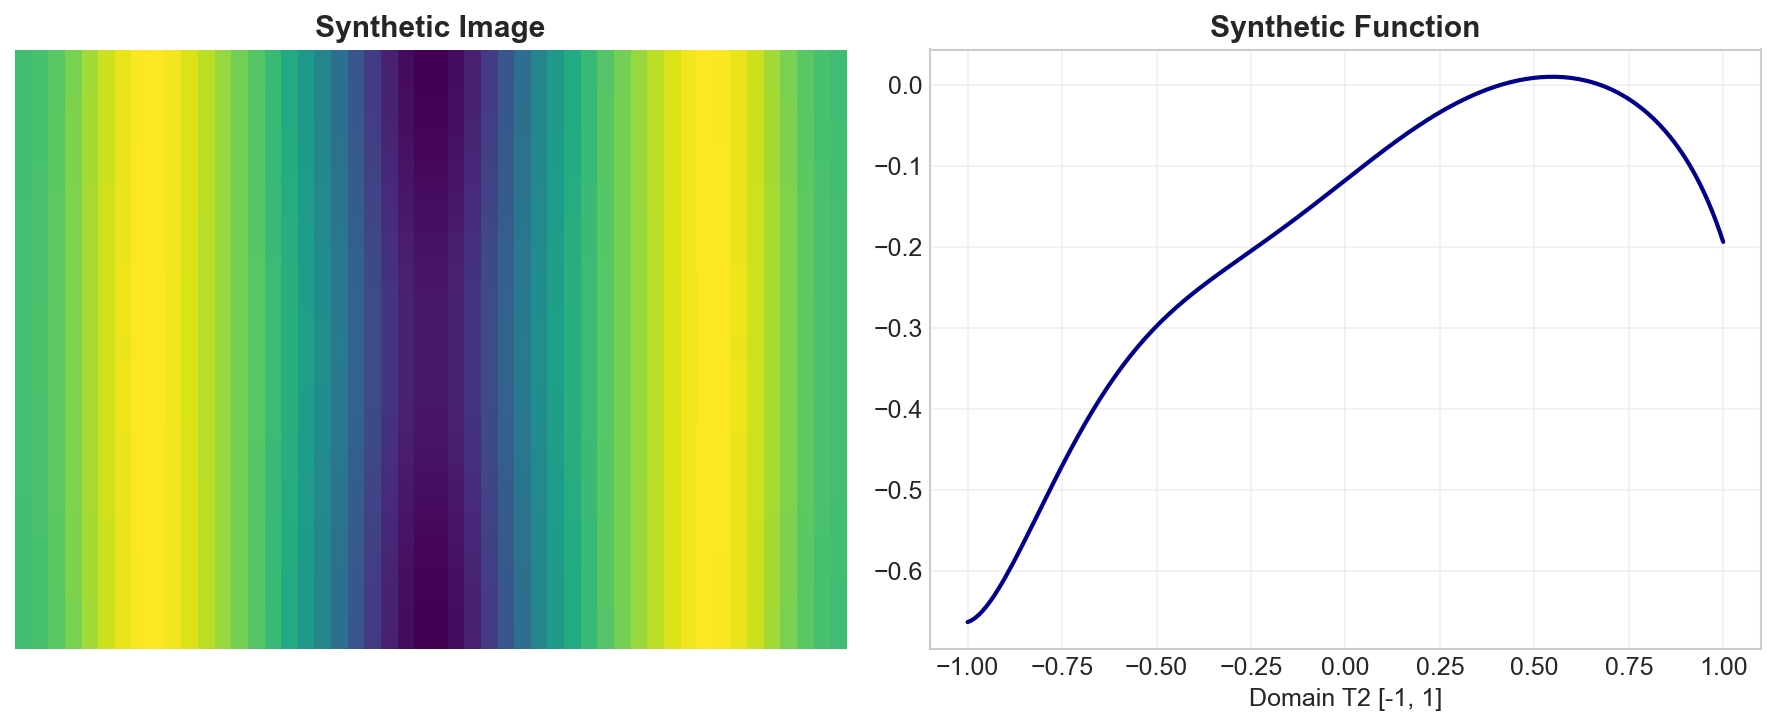

In [12]:
np.random.seed(42)
seed = 42
n_samples = 100
n_components = 3
show_plots = True  
all_results = {}



# 1. Simulación


sim_results = run_simulation(seed, n_samples, show_plots)
all_results.update(sim_results)

### 4.a.2 Usando el artículo de Rousseeuw, P. J., Raymaekers, J., & Hubert, M. (2018), encuentre imágenes outliers y retírelas del dataset.

**The main idea is to split the sample into two half samples, and then to apply a robust scale estimator to each of them.**

---
Se separa el conjunto de datos en dos grupos partiendo en 
$$ h = \frac{n + 1}{2}$$ 

entonces se define en caso **par**,


$$Y_b = \{y_{1}, \dots, y_h\}$$
$$Y_a = \{y_{h+1}, \dots, y_n\}$$

en caso **impar**,


$$Y_b = \{y_{1}, \dots, y_h\}$$
$$Y_a = \{y_{h}, \dots, y_n\}$$

---
Sea la estimación inicial

$$ S_{0, a}(Y) = \frac{med(Z_a)}{\phi^{-1}(0.75)}$$
$$ S_{0, b}(Y) = \frac{med(Z_b)}{\phi^{-1}(0.75)}$$

Donde $Z_a = Y_a - med(Y)$ y $Z_b = med(Y) - Y_b$ y donde $\phi^{-1}(0.75)$ asegura "consistensy" en una gaussiana.

El primer paso de M-estimación son dados por,

$$ S_a (Y) = S_{0, a}(Y) \sqrt{\frac{1}{2\alpha h} \sum_{z_i \in Z_a} \rho_c\left(\frac{z_i}{S_{0, a}(Y)}\right) }$$

$$ S_b (Y) = S_{0, b}(Y) \sqrt{\frac{1}{2\alpha h} \sum_{z_i \in Z_b} \rho_c\left(\frac{z_i}{S_{0, b}(Y)}\right) }$$

Donde, $ h = \left\lfloor\frac{n+1}{2}\right\rfloor$,  $\alpha = \int_0^{\infty} \rho_c(x)d\Phi(x)$.$\rho_c$ La funcion de hubert de escala y $\rho_c(t) = \left(\frac{t}{c}\right)^2\mathbb{1}_{[-c,c]} + \mathbb{1}_{(-\infty,-c]\cup[c,\infty)}$


---
$$
\text{DO}(y; Y) = 
\begin{cases}
\frac{y-\text{med}(Y)}{s_a(Y)} & \text{if } y \geq \text{med}(Y) \\
\frac{\text{med}(Y)-y}{s_b(Y)} & \text{if } y \leq \text{med}(Y)
\end{cases}
$$

Se puede definir *functional directional outlyingness* (fDO) de X, con respecto a una muestra **Y** como,

$$
\text{fDO}(X; Y) = \sum^T_{j=1} DO(X(t_j); Y(t_j)) W(t_j)
$$

Donde $W(.)$ es una función de peso, tal que  $\sum^T_{j=1} W(t_j) = 1$.

Se considera que $DO_i$ tiene una distribución de cola a la derecha, entonces transformando

$$ \{ LDO_1, \dots, LDO_n\} = \{ log(0.1 + DO_1), \dots, log(0.1 + DO_n)\}$$

Se **aproxima** la distribución de $LDO_i$ a una normal, y se obtiene el valor de corte como,

$$\frac{LDO_i - med(LDO)}{MAD(LDO)} < \Phi^{-1}(0.995)$$

---

Se puede encontrar la variabilidad de los valores $DO_i$ como,

$$
vDO(y_i, Y) =\frac{stdev_j(DO(Y_i(t_j); Y(t_j)))}{1 + fDO(Y_i; Y)}
$$

Con lo anterior definido se puede encontrar el **FOM** (*functional outlier map*) como,

$$
(\text{fDO}(Y_i, \mathbf{Y}), \text{vDO}(Y_i, \mathbf{Y}))$$

Se puede definir *combined functional outlyingness* (CFO) de una función $Y_i$ como,

$$
CFO_i  = \sqrt{\left(\frac{\text{fDO}_i}{med(\text{fDO})}\right)^2 + \left(\frac{\text{vDO}_i}{med(\text{vDO})}\right)^2}

**APLICACIÓN A IMAGENES**

$$
\text{fDO}(Y_i; \mathbf{Y}) = \sum^J_{j=1}\sum^K_{k=1} DO(Y_i(j,k); \mathbf{Y}(j,k)) W_{jk}
$$
$$
\text{vDO}(Y_i; \mathbf{Y}) =\frac{stdev_{j,k}(DO(Y_i(j,k); \mathbf{Y}(j,k)))}{1 + fDO(Y_i; \mathbf{Y})}
$$

Y se toma los pesos tal que
$$
W_{j,k} = \frac{1}{(JK)}
$$

En este caso en especial, se toma 10x100x50

$$
\text{fDO}(Y_i; \mathbf{Y}) = \frac{1}{100 \times 50}\sum^{100}_{j=1}\sum^{50}_{k=1} DO(Y_i(j,k); \mathbf{Y}(j,k)) W_{jk}
$$



**Si se puede, no usar supuesto de normalidad.**

Detected [39 77 88] outliers


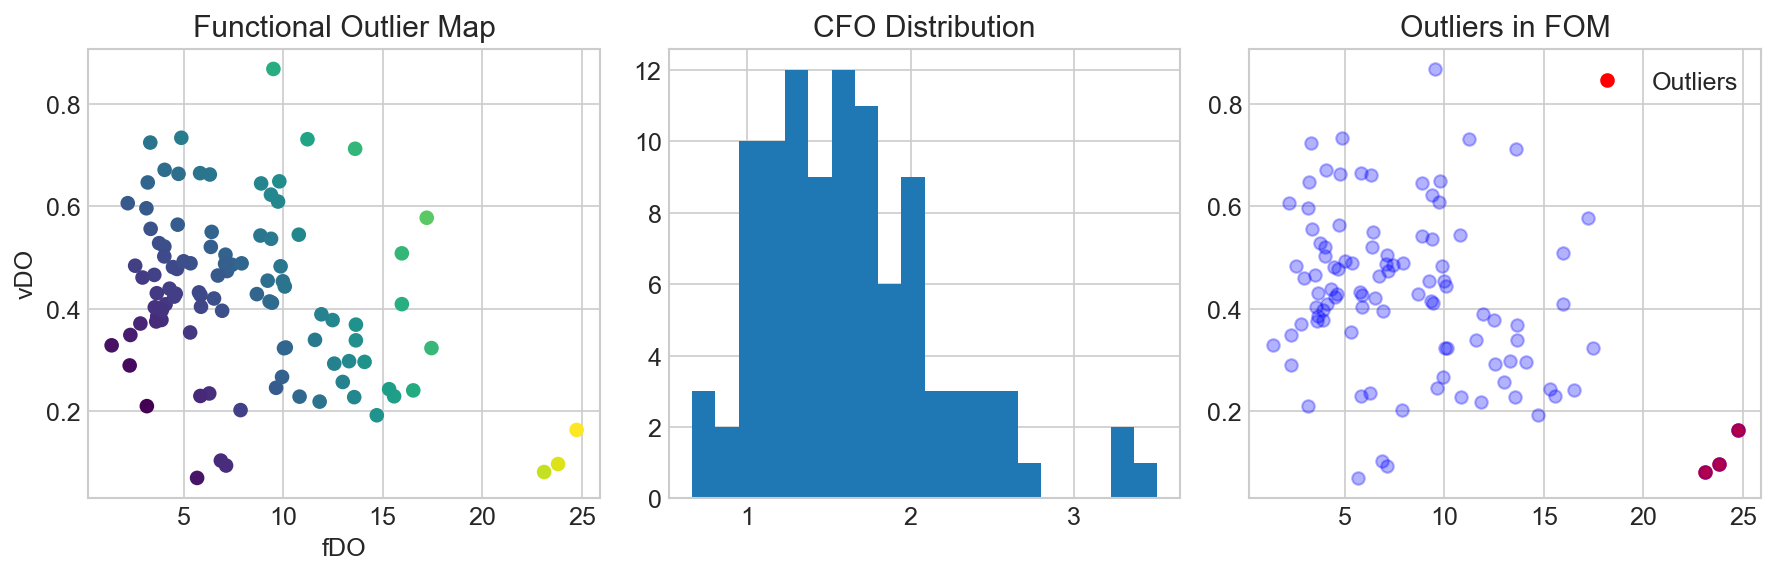

In [13]:
 
outlier_results = run_outlier_detection(all_results['images'], all_results['functions'], show_plots)
all_results.update(outlier_results)

si no se tiene como base esta suposición:



$$ \{ LDO_1, \dots, LDO_n\} = \{ log(0.1 + DO_1), \dots, log(0.1 + DO_n)\}$$

Se **aproxima** la distribución de $LDO_i$ a una **normal**, y se obtiene el valor de corte como,

$$\frac{LDO_i - med(LDO)}{MAD(LDO)} < \Phi^{-1}(0.995)$$
 
 y se cambia como el valor del corte a su distribución **empirica**, cambia los outliers

Detected [88] outliers using empirical method


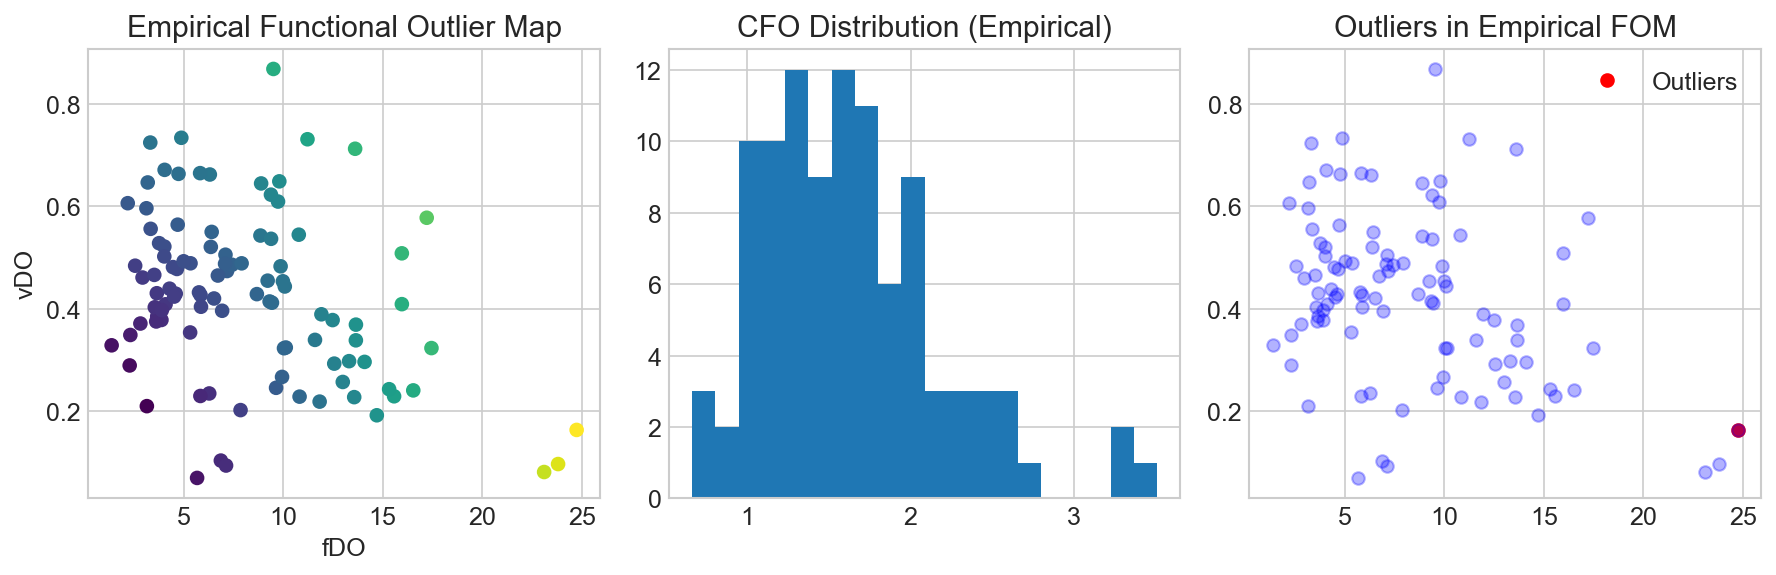

In [14]:
outlier_results = run_outlier_detection_empiric(all_results['images'], all_results['functions'], show_plots)
all_results.update(outlier_results)

#### Comparación Resumida: Similitudes y Diferencias

Metodología 1: Taller anterior

Metodología 2: Taller actual

| **Aspecto**               | **Similitudes**                                                                 | **Diferencias**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| **Objetivo**              | Detectar *outliers* en datos funcionales.                                       | Metodología 1: Enfocada en multivariados. <br> Metodología 2: Adaptada a imágenes/univariados. |
| **Robustez**              | Ambas usan técnicas robustas contra outliers.                                   | M1: Basada en MCD (covarianza). <br> M2: Usa M-estimación + división de muestras. |
| **Métricas**              | Combinan múltiples métricas para detectar outliers.                             | M1: `FO`, `MO`, `VO` + `RMD²`. <br> M2: `fDO`, `vDO` + `CFO`.                   |
| **Enfoque de Atipicidad** | Consideran dirección y magnitud de desviación.                                  | M1: Anomalía direccional funcional (vectorial). <br> M2: Outlyingness asimétrico respecto a la mediana. |
| **Supuestos**             | Requieren definir funciones de peso (\(w(t)\) o \(W(t_j)\)).                   | M1: Asume normalidad aproximada para el corte. <br> M2: Usa transformación log + MAD no paramétrico. |
| **Aplicabilidad**         | Efectivas en dominios funcionales.                                              | M1: Procesos estocásticos multivariados. <br> M2: Imágenes/datos univariados.    |
| **Complejidad**           | Ambas implican integración/suma ponderada.                                      | M1: Mayor complejidad en integración multivariada. <br> M2: Cálculos más simples por enfoque univariado. |

### 4.a.3 Usando el artículo de Allen, G. I. (2013), encuentre las eigenimages y sus respectivos valores propios

Explicación del Método **F-CP-TPA** (Functional CP-Tensor Power Algorithm)

 **Contexto**
El **F-CP-TPA** es un método de descomposición tensorial funcional que combina:
1. **Descomposición CP** (CANDECOMP/PARAFAC): Representa un tensor como suma de componentes de rango 1.
2. **Regularización de suavidad**: Incorpora restricciones para que los factores sean funciones suaves.
3. **Algoritmo de Potencia Tensorial (TPA)**: Actualiza los factores de forma iterativa y "greedy" (uno a la vez).

Es ideal para datos multi-way (ej: imágenes 3D, series temporales multivariadas) donde los factores subyacentes tienen estructura suave (ej: señales cerebrales en neuroimagen, patrones climáticos).

---

 **¿Cómo funciona?**

 **Paso 1: Modelo CP Regularizado**
El tensor $\mathcal{X} \in \mathbb{R}^{n \times p \times q}$ se aproxima como:
$$
\mathcal{X} \approx \sum_{k=1}^K d_k \, \mathbf{u}_k \circ \mathbf{v}_k \circ \mathbf{w}_k + \epsilon
$$
donde:
- $\mathbf{u}_k, \mathbf{v}_k, \mathbf{w}_k$: Factores suaves en cada modo.
- $d_k$: Peso escalar del componente $k$.
- $\epsilon$: Ruido.

 **Paso 2: Función de Pérdida con Penalización**
Se minimiza un criterio que combina:
- Error de reconstrucción (Frobenius).
- Penalización de suavidad ($\ell_2$) en los factores:
$$
\min_{\mathbf{u}, \mathbf{v}, \mathbf{w}} \left\| \mathcal{X} - \mathbf{u} \circ \mathbf{v} \circ \mathbf{w} \right\|_F^2 + \alpha \left( \mathbf{u}^T \Omega \mathbf{u} + \mathbf{v}^T \Omega \mathbf{v} + \mathbf{w}^T \Omega \mathbf{w} \right)
$$
- $\Omega$: Matriz de penalización (ej: diferencias finitas para suavidad).
- $\alpha$: Parámetro de regularización.

---

 **Algoritmo F-CP-TPA**

 **Paso 1: Inicialización**
- Fijar $\mathcal{X}' = \mathcal{X}$ (tensor original).
- Inicializar factores $\mathbf{u}, \mathbf{v}, \mathbf{w}$ con norma unitaria.

 **Paso 2: Bucle Greedy (Componente por Componente)**
Para cada componente $k = 1, \ldots, K$:
1. **Actualizar Factores** (hasta convergencia):
   - **Modo 1 ($\mathbf{u}_k$)**:
    $$
     \mathbf{u}_k \leftarrow \frac{\mathbf{S}_u (\mathcal{X}' \times_2 \mathbf{v}_k \times_3 \mathbf{w}_k)}{\mathbf{v}_k^T \mathbf{S}_v^{-1} \mathbf{v}_k \cdot \mathbf{w}_k^T \mathbf{S}_w^{-1} \mathbf{w}_k}
     $$
   - **Modo 2 ($\mathbf{v}_k$)** y **Modo 3 ($\mathbf{w}_k$)**: Análogo.
   
   - $\mathbf{S}_u = (\mathbf{I} + \alpha \Omega)^{-1}$: Matriz de suavizado.

2. **Escalar** $\mathbf{u}_k, \mathbf{v}_k, \mathbf{w}_k$ a norma unitaria.

3. **Calcular Peso $d_k$**:
  $$
   d_k = \mathcal{X}' \times_1 \mathbf{u}_k \times_2 \mathbf{v}_k \times_3 \mathbf{w}_k
   $$

4. **Sustraer Componente**:
  $$
   \mathcal{X}' \leftarrow \mathcal{X}' - d_k \cdot \mathbf{u}_k \circ \mathbf{v}_k \circ \mathbf{w}_k
   $$

---

 **Claves del Método**
1. **Enfoque Greedy**:
   - Extrae componentes uno a uno, lo que acelera el cómputo.
   - Cada componente se estima sobre los residuos del anterior.

2. **Regularización de Suavidad**:
   - Las matrices $\mathbf{S}_u, \mathbf{S}_v, \mathbf{S}_w$ suavizan los factores.
   - Penaliza rugosidades (ej: oscilaciones bruscas en señales).

3. **Optimización Tri-Convexa**:
   - El problema es convexo en cada factor por separado.
   - Converge a un punto estacionario garantizado.

---

 **Ventajas vs. Otros Métodos**
| **Característica**       | **F-CP-TPA**                                  | **F-HOSVD / F-CP-ALS**                     |
|--------------------------|-----------------------------------------------|---------------------------------------------|
| **Convergencia**         | Garantizada (punto estacionario).             | Depende de inicialización.                  |
| **Velocidad**            | Más rápido (componentes greedy).              | Lento (SVD iterativas / ecuaciones complejas). |
| **Recuperación de Señal**| Mejor en datos suaves (Tabla II).              | Menor precisión en algunos casos.           |
| **Parámetros**           | $\alpha$ ajustable por validación cruzada.  | Múltiples parámetros difíciles de calibrar. |

---

 **Aplicaciones Prácticas**
- **Neuroimagen**: Extraer patrones cerebrales suaves de datos fMRI.
- **Climatología**: Identificar tendencias suaves en datos espacio-temporales.
- **Imágenes Médicas**: Compresión de datos 3D con preservación de estructura.

---


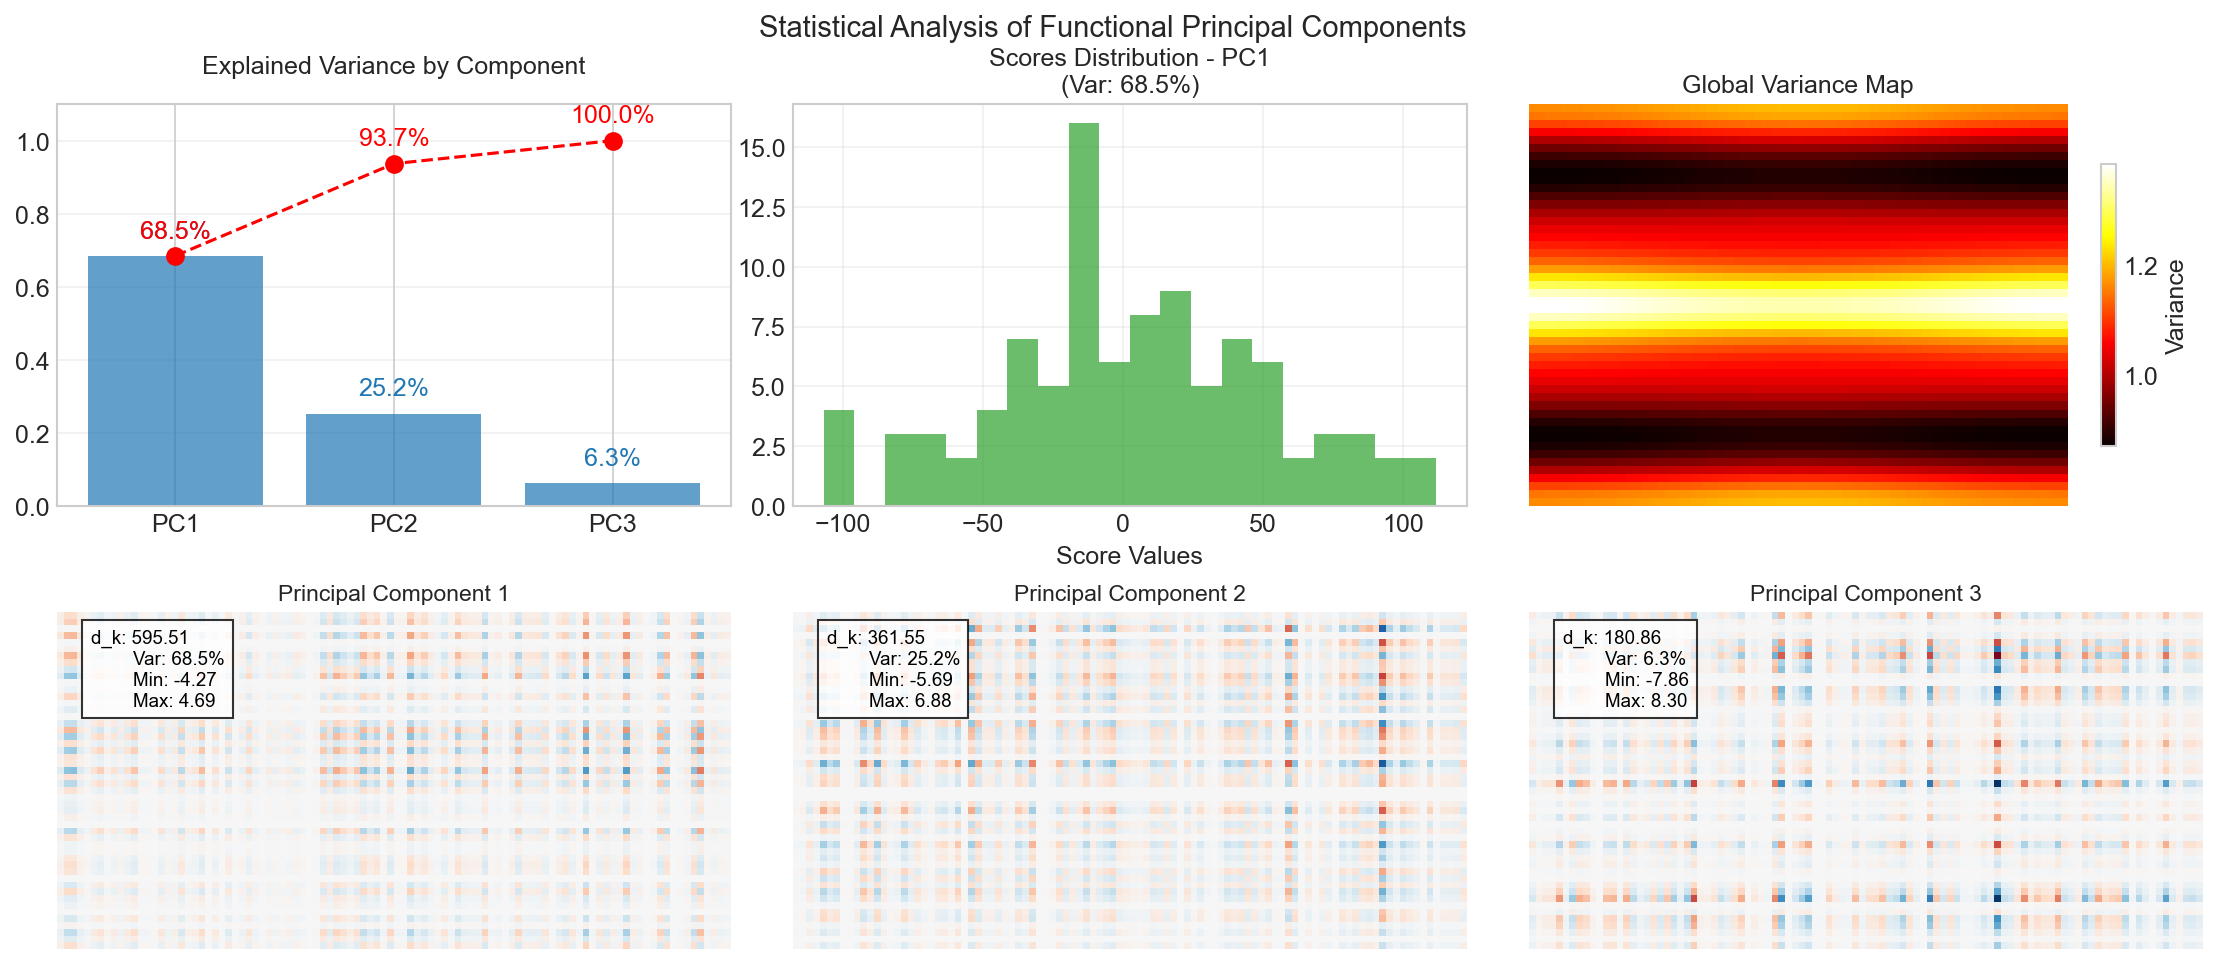

In [15]:
tpa_results = run_tpa_analysis(all_results['clean_images'], seed, n_components, show_plots)
all_results.update(tpa_results)  

### 4.a.4. Encuentre las funciones propias y valores propios de las curvas

 **FPCA en scikit-fda: Explicación y Ecuaciones Clave**

El paquete **scikit-fda** implementa el **Análisis de Componentes Principales Funcionales (FPCA)** para reducir la dimensionalidad de datos funcionales (ej: curvas, imágenes) preservando la máxima varianza. Aquí se explica su funcionamiento:

---

 **1. Modelo Matemático de FPCA**

Un dato funcional $ X(t) $ se representa como:
$$
X(t) = \mu(t) + \sum_{j=1}^{\infty} \xi_j \phi_j(t),
$$
donde:
- $ \mu(t) = \mathbb{E}[X(t)] $: **Media funcional**.
- $ \phi_j(t) $: **Componentes principales** (funciones ortogonales).
- $ \xi_j = \langle X - \mu, \phi_j \rangle $: **Scores** (proyecciones no correlacionadas).

---

 **2. Estimación en scikit-fda**

 **Paso 1: Centrar los Datos**
Se calcula la media muestral:
$$
\hat{\mu}(t) = \frac{1}{N} \sum_{i=1}^N x_i(t),
$$
y se centran las observaciones: $ x_i^{\text{centrado}}(t) = x_i(t) - \hat{\mu}(t) $.

 **Paso 2: Matriz de Covarianza**
La covarianza funcional se estima como:
$$
\hat{C}(t, s) = \frac{1}{N-1} \sum_{i=1}^N x_i^{\text{centrado}}(t) \cdot x_i^{\text{centrado}}(s).
$$

 **Paso 3: Descomposición en Valores Singulares (SVD)**
Se aplica SVD a la matriz de datos centrada $ \mathbf{X}_{\text{centrado}} \in \mathbb{R}^{N \times M} $:
$$
\mathbf{X}_{\text{centrado}} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T,
$$
donde:
- $ \mathbf{V} $: Componentes principales discretizados ($ \phi_j(t) $).
- $ \mathbf{U} \mathbf{\Sigma} $: Scores ($ \xi_j $).

---

 **3. Regularización para Suavizado**

Para obtener componentes principales suaves, **scikit-fda** añade una penalización a la rugosidad. Por ejemplo, usando la norma $ L^2 $ de la segunda derivada:
$$
\text{maximizar} \left(\text{Var}(\xi_j) - \alpha \int \left( \phi_j''(t) \right)^2 dt\right),
$$
donde $ \alpha $ controla el suavizado. Esto se implementa resolviendo:
$$
\mathbf{X}_{\text{centrado}}^T \mathbf{X}_{\text{centrado}} \mathbf{V} + \alpha \mathbf{\Omega} \mathbf{V} = \mathbf{V} \mathbf{\Lambda},
$$
con $ \mathbf{\Omega} $ como matriz de penalización (ej: diferencias finitas).

**4. Resultados**




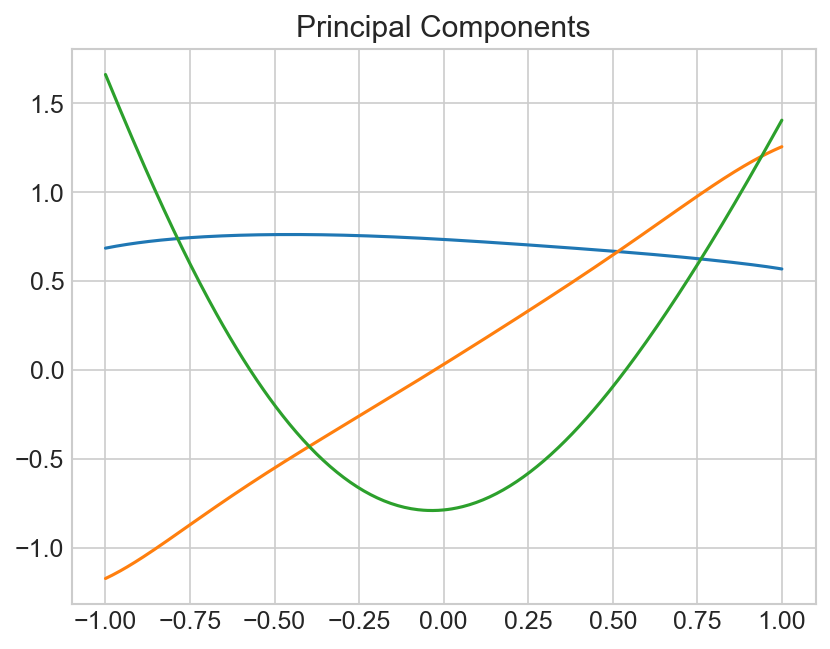

In [16]:
fpca_results = run_fpca(all_results['clean_functions'], n_components, show_plots)
all_results.update(fpca_results)

### 4.a.5.Usando la metodología propuesta por Happ, C., & Greven, S. (2018, encuentre las funciones propias multidimensionales y sus respectivos valores propios.

 Propuesta de Análisis de Componentes Principales Funcionales Multivariantes (MFPCA) para Datos en Dominios de Diferente Dimensión

 1. Fundamentos Teóricos

 1.1. Estructura de Datos y Notación  
Sea $ X = (X^{(1)}, \ldots, X^{(p)}) $ un vector de datos funcionales multivariantes, donde cada elemento $ X^{(j)}: \mathcal{T}_j \rightarrow \mathbb{R} $ pertenece a $ L^2(\mathcal{T}_j) $, con $ \mathcal{T}_j \subset \mathbb{R}^{d_j} $ compacto y de medida finita. Se asume que:  
$$
\mu(\mathbf{t}) = \mathbb{E}[X(\mathbf{t})] = \mathbf{0}, \quad \forall \mathbf{t} \in \mathcal{T} = \mathcal{T}_1 \times \cdots \times \mathcal{T}_p.
$$  
La matriz de covarianzas se define como:  
$$
C_{ij}(s_i, t_j) = \text{cov}\left(X^{(i)}(s_i), X^{(j)}(t_j)\right), \quad s_i \in \mathcal{T}_i, \, t_j \in \mathcal{T}_j.
$$

 1.2. Espacio de Hilbert Multivariante  
El espacio $ \mathcal{H} = L^2(\mathcal{T}_1) \times \cdots \times L^2(\mathcal{T}_p) $ se equipa con el producto interno:  
$$
\langle\langle f, g \rangle\rangle_\omega = \sum_{j=1}^p w_j \int_{\mathcal{T}_j} f^{(j)}(t_j) g^{(j)}(t_j) dt_j,
$$  
donde $ w_j > 0 $ son pesos para ajustar diferencias en dominios, rangos o variabilidad.

 1.3. Operador de Covarianza  
El operador de covarianza $ \Gamma: \mathcal{H} \rightarrow \mathcal{H} $ se define componente a componente como:  
$$
(\Gamma f)^{(j)}(t_j) = \sum_{i=1}^p \int_{\mathcal{T}_i} C_{ij}(s_i, t_j) f^{(i)}(s_i) ds_i.
$$  
**Proposición 1**:  
- $ \Gamma $ es lineal, autoadjunto y positivo.  
- Si $ C_{ij} $ es uniformemente continua y acotada, $ \Gamma $ es compacto.  

---

 2. Teorema de Karhunen-Loève Multivariante

**Proposición 4 (Karhunen-Loève Multivariante)**:  
Bajo las condiciones de la Proposición 1, $ X(\mathbf{t}) $ admite la representación:  
$$
X(\mathbf{t}) = \sum_{m=1}^\infty \rho_m \psi_m(\mathbf{t}),
$$  
donde:  
- $ \{\psi_m\} \subset \mathcal{H} $ son eigenfunciones ortonormales de $ \Gamma $.  
- $ \rho_m = \langle\langle X, \psi_m \rangle\rangle $ son variables aleatorias no correlacionadas con $ \mathbb{E}[\rho_m] = 0 $ y $ \text{var}(\rho_m) = v_m $, siendo $ v_m $ los autovalores de $ \Gamma $.  

La convergencia es uniforme en $ \mathcal{T} $, y la aproximación truncada:  
$$
X_{[M]}(\mathbf{t}) = \sum_{m=1}^M \rho_m \psi_m(\mathbf{t}),
$$  
minimiza el error cuadrático medio $ \mathbb{E}\left[\|X - X_{[M]}\|^2\right] $.

---

 3. Relación entre FPCA Univariante y MFPCA

**Proposición 5**:  
1. **De MFPCA a FPCA Univariante**:  
   Si $ X $ tiene una representación finita de Karhunen-Loève con $ M $ términos, los autovalores $ \lambda_m^{(j)} $ de cada elemento $ X^{(j)} $ corresponden a los autovalores de la matriz $ A^{(j)} \in \mathbb{R}^{M \times M} $ con entradas:  
   $$
   A_{mn}^{(j)} = \sqrt{v_m v_n} \int_{\mathcal{T}_j} \psi_m^{(j)}(t_j) \psi_n^{(j)}(t_j) dt_j.
   $$  
   Las eigenfunciones univariantes $ \phi_m^{(j)} $ se obtienen como:  
   $$
   \phi_m^{(j)}(t_j) = \frac{1}{\sqrt{\lambda_m^{(j)}}} \sum_{n=1}^M \sqrt{v_n} [\mathbf{u}_m^{(j)}]_n \psi_n^{(j)}(t_j),
   $$  
   donde $ \mathbf{u}_m^{(j)} $ es el $ m $-ésimo autovector de $ A^{(j)} $.

2. **De FPCA Univariante a MFPCA**:  
   Si cada $ X^{(j)} = \sum_{m=1}^{M_j} \xi_m^{(j)} \phi_m^{(j)} $, los autovalores $ v_m $ de $ \Gamma $ corresponden a los autovalores de la matriz $ Z \in \mathbb{R}^{M_+ \times M_+} $ ($ M_+ = \sum_{j=1}^p M_j $) con bloques:  
   $$
   Z_{mn}^{(jk)} = \text{cov}\left(\xi_m^{(j)}, \xi_n^{(k)}\right).
   $$  
   Las eigenfunciones multivariantes $ \psi_m $ se construyen como:  
   $$
   \psi_m^{(j)}(t_j) = \sum_{n=1}^{M_j} [\mathbf{c}_m^{(j)}]_n \phi_n^{(j)}(t_j),
   $$  
   donde $ \mathbf{c}_m $ es el $ m $-ésimo autovector de $ Z $.

---

 4. Algoritmo de Estimación

 Pasos:  
1. **FPCA Univariante por Elemento**:  
   - Para cada $ X^{(j)} $, estimar $ \hat{\phi}_m^{(j)} $ y scores $ \hat{\xi}_{i,m}^{(j)} $ ($ i = 1, \ldots, N $) usando métodos como PACE (Yao et al., 2005) o suavizado con splines.  
   - Seleccionar truncamientos $ M_j $ mediante scree plots o porcentaje de varianza explicada.  

2. **Construir Matriz de Covarianzas de Scores**:  
   - Definir $ \mathbf{E} \in \mathbb{R}^{N \times M_+} $, donde cada fila contiene los scores $ (\hat{\xi}_{i,1}^{(1)}, \ldots, \hat{\xi}_{i,M_p}^{(p)}) $.  
   - Calcular $ \hat{Z} = \frac{1}{N-1} \mathbf{E}^T \mathbf{E} $.  

3. **Descomposición Espectral de $ \hat{Z} $**:  
   - Obtener autovalores $ \hat{v}_1 \geq \hat{v}_2 \geq \cdots $ y autovectores ortonormales $ \hat{\mathbf{c}}_1, \hat{\mathbf{c}}_2, \ldots $.  

4. **Componentes Multivariantes Estimados**:  
   - **Eigenfunciones**:  
     $$
     \hat{\psi}_m^{(j)}(t_j) = \sum_{n=1}^{M_j} [\hat{\mathbf{c}}_m^{(j)}]_n \hat{\phi}_n^{(j)}(t_j).
     $$  
   - **Scores**:  
     $$
     \hat{\rho}_{i,m} = \sum_{j=1}^p \sum_{n=1}^{M_j} [\hat{\mathbf{c}}_m^{(j)}]_n \hat{\xi}_{i,n}^{(j)}.
     $$  



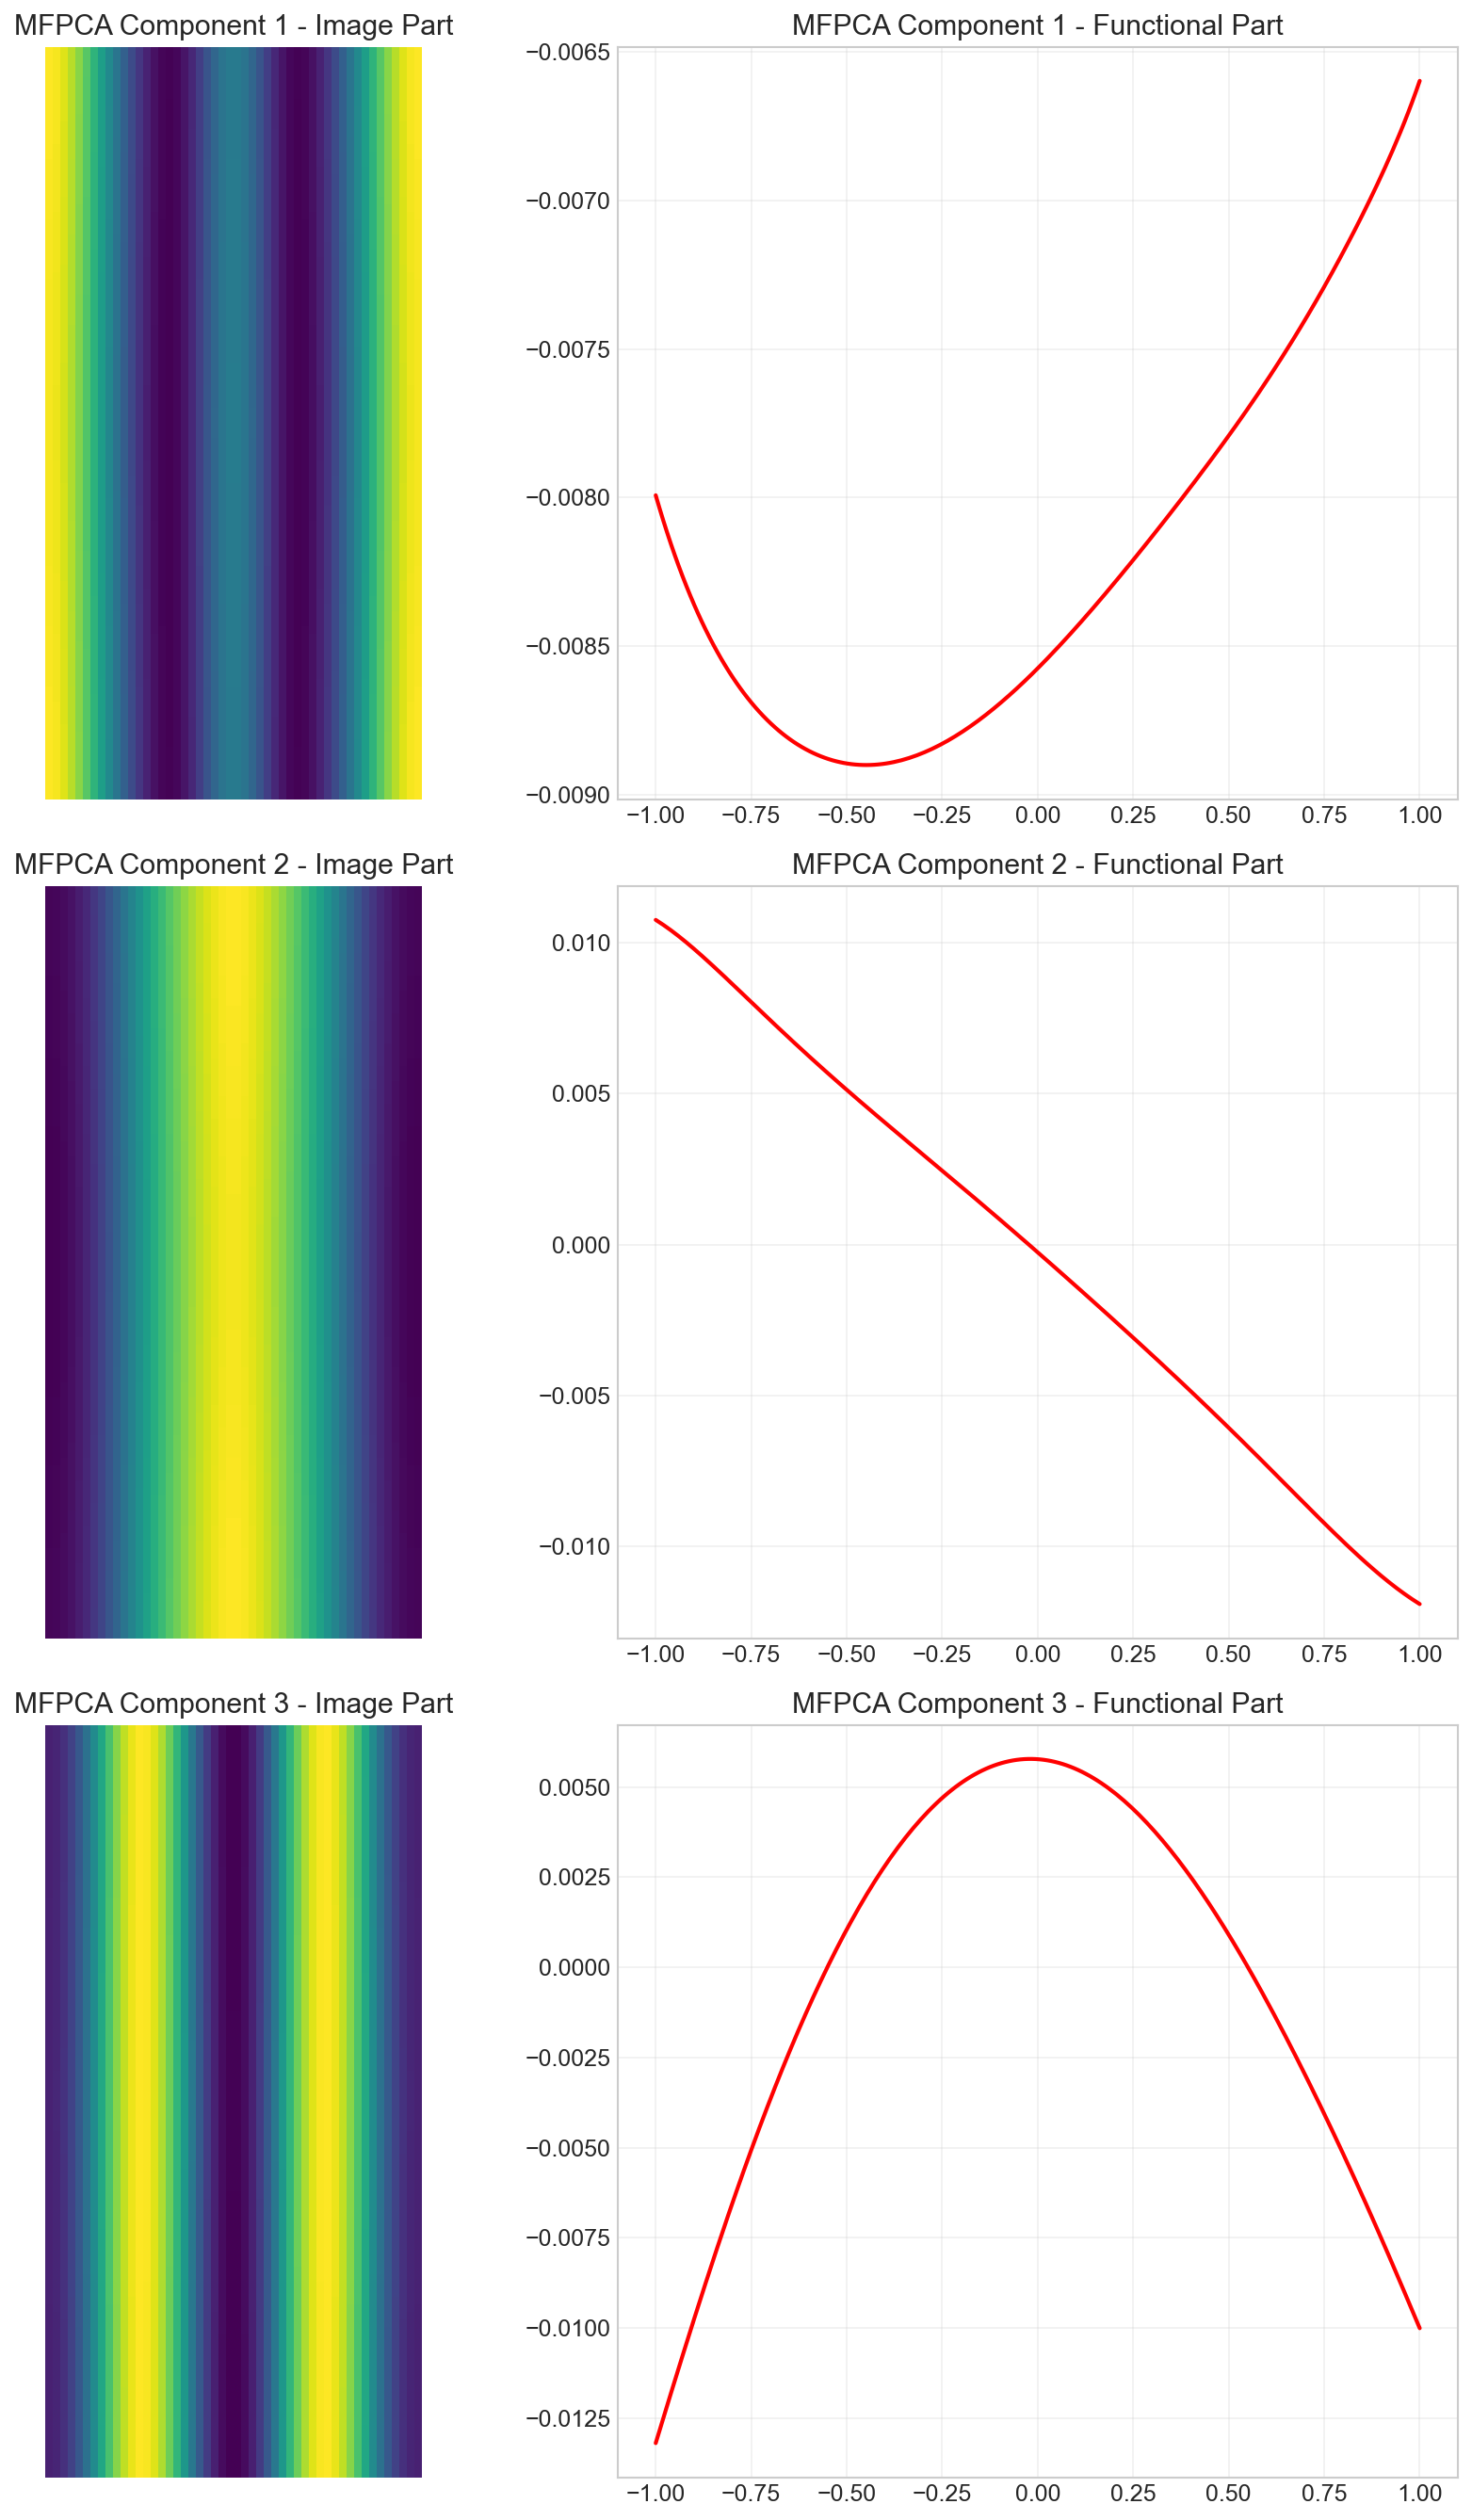

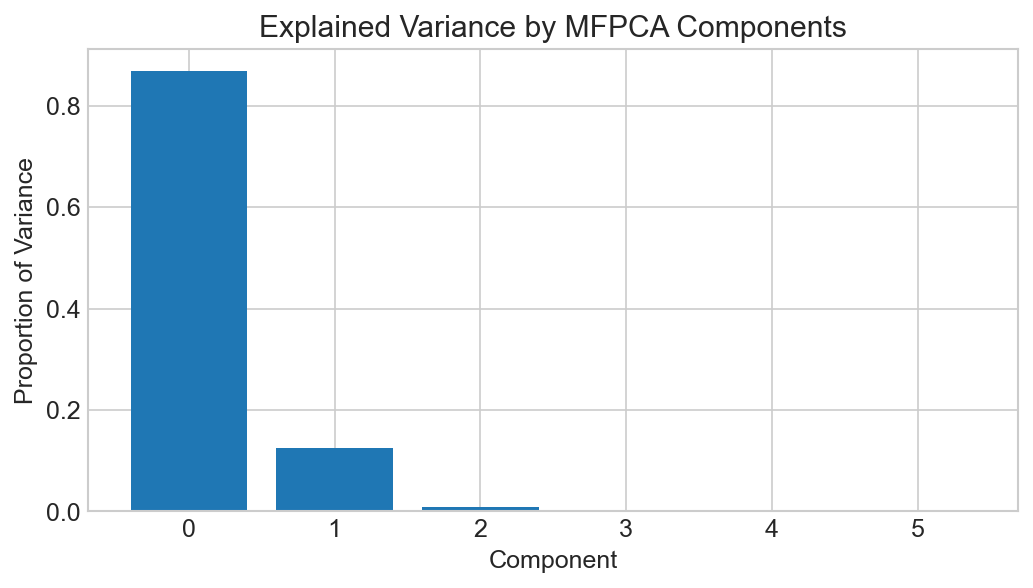

In [17]:
mfpca_results = run_mfpca(all_results['clean_images'], all_results['clean_functions'], 
                             n_components, show_plots)
all_results.update(mfpca_results)


## 4.b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skfda.preprocessing.dim_reduction import FPCA
from sklearn.utils import resample
from tqdm import tqdm

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.dpi': 150})

class MFPCA_ADNI:
    def __init__(self, n_components=3, n_bootstrap=100):
        self.n_components = n_components
        self.n_bootstrap = n_bootstrap
        self.weights_ = None
        self.components_ = None
        self.bootstrap_results_ = None

    def _preprocess_data(self, data):
        """Preprocesamiento de datos ADNI"""
        # Asumimos que el DataFrame contiene:
        # - 'subject_id': identificador único
        # - 'time': puntos temporales
        # - 'ADAS_Cog': puntuaciones cognitivas
        # - 'PET_image': arrays de imágenes 2D aplanadas
        
        # Procesar datos funcionales (ADAS-Cog)
        func_data = data.pivot(index='subject_id', columns='time', values='ADAS_Cog')
        self.times = func_data.columns.values
        self.func_matrix = func_data.values
        
        # Procesar datos de imagen (PET)
        self.image_shape = (93, 117)  # Dimensión de las imágenes axiales
        self.image_matrix = np.stack(data.groupby('subject_id')['PET_image'].first().apply(np.reshape, args=self.image_shape))
        
        return self.func_matrix, self.image_matrix

    def _calculate_weights(self, func_var, image_var):
        """Calcular pesos según varianza integrada"""
        total_func_var = np.trapz(func_var, x=self.times)
        total_image_var = np.sum(image_var)
        self.weights_ = np.array([1/total_func_var, 1/total_image_var])
        self.weights_ /= self.weights_.sum()
        return self

    def _univariate_fpca(self):
        """FPCA univariante para cada modalidad"""
        # FPCA para datos funcionales
        fd = skfda.FDataGrid(self.func_matrix, grid_points=self.times)
        self.func_fpca = FPCA(n_components=self.n_components)
        self.func_scores = self.func_fpca.fit_transform(fd)
        self.func_components = self.func_fpca.components_.data_matrix.squeeze()
        
        # PCA para imágenes
        flat_images = self.image_matrix.reshape(len(self.image_matrix), -1)
        self.image_pca = PCA(n_components=self.n_components)
        self.image_scores = self.image_pca.fit_transform(flat_images)
        self.image_components = self.image_pca.components_.reshape(
            self.n_components, *self.image_shape)
        
        # Calcular pesos
        self._calculate_weights(np.var(self.func_matrix, axis=0),
                               np.var(flat_images, axis=0))
        
        return self

    def _multivariate_pca(self, scores):
        """Análisis multivariante de scores combinados"""
        scores_weighted = scores * np.sqrt(self.weights_[:, np.newaxis])
        self.mv_pca = PCA(n_components=self.n_components)
        self.mv_scores = self.mv_pca.fit_transform(scores_weighted)
        self.components_ = self.mv_pca.components_
        return self

    def _bootstrap_components(self):
        """Bootstrapping para intervalos de confianza"""
        bootstrap_samples = []
        combined_scores = np.hstack([self.func_scores, self.image_scores])
        
        for _ in tqdm(range(self.n_bootstrap), desc='Bootstrapping'):
            resampled_scores = resample(combined_scores)
            pca = PCA(n_components=self.n_components)
            pca.fit(resampled_scores * np.sqrt(self.weights_[:, np.newaxis]))
            
            # Alinear componentes con signo original
            aligned_components = pca.components_ * np.sign(
                pca.components_.dot(self.components_.T))
            
            bootstrap_samples.append(aligned_components)
        
        self.bootstrap_results_ = np.array(bootstrap_samples)
        return self

    def fit(self, data):
        """Pipeline completo de análisis"""
        # 1. Preprocesamiento
        self.func_matrix, self.image_matrix = self._preprocess_data(data)
        
        # 2. FPCA univariante
        self._univariate_fpca()
        
        # 3. Combinar scores y MFPCA
        combined_scores = np.hstack([self.func_scores, self.image_scores])
        self._multivariate_pca(combined_scores)
        
        # 4. Bootstrapping
        self._bootstrap_components()
        
        return self

    def plot_components(self):
        """Visualización con bandas de confianza bootstrap"""
        fig, axs = plt.subplots(self.n_components, 2, 
                              figsize=(14, 5*self.n_components),
                              gridspec_kw={'width_ratios': [1, 2]})
        
        for i in range(self.n_components):
            # Componente funcional
            func_component = self.components_[i, :len(self.func_components)]
            func_boot = self.bootstrap_results_[:, i, :len(self.func_components)]
            
            # Componente de imagen
            img_component = self.components_[i, len(self.func_components):]
            img_boot = self.bootstrap_results_[:, i, len(self.func_components):]
            
            # Visualización funcional
            self._plot_functional_component(axs[i,0], func_component, func_boot)
            
            # Visualización de imagen
            self._plot_image_component(axs[i,1], img_component, img_boot)
        
        plt.tight_layout()
        plt.show()

    def _plot_functional_component(self, ax, component, bootstrap_samples):
        """Visualizar componente funcional con bandas de confianza"""
        # Calcular intervalos
        lower = np.percentile(bootstrap_samples, 2.5, axis=0)
        upper = np.percentile(bootstrap_samples, 97.5, axis=0)
        
        # Graficar
        ax.fill_between(self.times, lower, upper, color='gray', alpha=0.3)
        ax.plot(self.times, component, color='darkblue', linewidth=2)
        ax.set_title(f'Componente Funcional {i+1}\nVarianza: {self.mv_pca.explained_variance_ratio_[i]:.1%}')
        ax.set_xlabel('Tiempo (años)')
        ax.grid(alpha=0.3)

    def _plot_image_component(self, ax, component, bootstrap_samples):
        """Visualizar componente de imagen con significancia"""
        # Remodelar componente
        img_component = component.reshape(self.image_shape)
        
        # Calcular significancia bootstrap
        boot_components = bootstrap_samples.reshape(-1, *self.image_shape)
        lower = np.percentile(boot_components, 2.5, axis=0)
        upper = np.percentile(boot_components, 97.5, axis=0)
        
        # Máscara de significancia
        significant_mask = (lower * upper) > 0  # Intervalo no contiene cero
        
        # Graficar
        img = ax.imshow(img_component, cmap='coolwarm', aspect='auto', origin='lower')
        ax.contour(significant_mask, colors='black', linewidths=0.5, alpha=0.7)
        plt.colorbar(img, ax=ax, shrink=0.7)
        ax.set_title(f'Componente de Imagen {i+1}')
        ax.axis('off')

# Uso del código
if __name__ == "__main__":
    # Cargar datos (asumiendo estructura específica)
    # data = pd.read_csv('adni_data.csv')
    
    # Ejemplo de estructura esperada:
    data = pd.DataFrame({
        'subject_id': np.repeat(np.arange(100)),  # 100 sujetos
        'time': np.tile(np.linspace(0, 5, 4)),  # 4 puntos temporales
        'ADAS_Cog': np.random.normal(size=400),  # Datos simulados
        'PET_image': [np.random.rand(93*117) for _ in range(400)]  # Imágenes aplanadas
    })
    
    # Inicializar y ejecutar análisis
    analyzer = MFPCA_ADNI(n_components=3, n_bootstrap=100)
    analyzer.fit(data)
    
    # Visualizar resultados
    analyzer.plot_components()